# LSTM vs GRU

In [1]:
import numpy as np
from collections import Counter
import nltk
from matplotlib import pyplot as plt
import pandas as pd
import time
from nltk.corpus import stopwords
%matplotlib inline

## Data loading

In [2]:
# Loading in the training data with Pandas 
# Data from Kaggle Spooky author competition
train = pd.read_csv("input/train.csv", encoding='utf8')
test = pd.read_csv("input/test.csv", encoding='utf8')

In [3]:
train['text'] = train['text'].str.lower()
stemmer = nltk.stem.SnowballStemmer('english')
#train['stemmed'] = train["text"].apply(lambda x:"".join(list(map(stemmer.stem, x))))

# Text Classification the old way

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

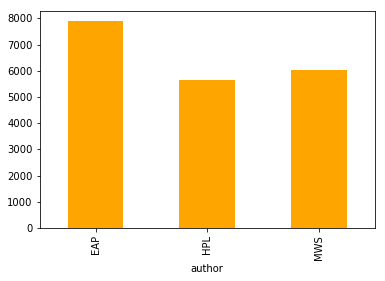

In [40]:
train.groupby(['author']).count()['count'].plot(kind='bar', color = 'orange')

In [5]:
train['target'] =  [1 if v == 'EAP' else 2 if v == 'HPL' else 3 for v in train['author']]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 4 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
target    19579 non-null int64
dtypes: int64(1), object(3)
memory usage: 611.9+ KB


In [7]:
train.describe(include = 'all')

,id,text,author,target
count,19579,19579,19579,19579.000000
unique,19579,19578,3,NaN
top,id13281,and yet how unintelligible is this in all othe...,EAP,NaN
freq,1,2,7900,NaN
mean,NaN,NaN,NaN,1.905205
std,NaN,NaN,NaN,0.838595
min,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,3.000000


In [8]:
train.groupby('author').describe(include = 'all')

id                                                    ...    text  \
       count unique      top freq mean  std  min  25%  50%  75% ...  unique   
author                                                          ...           
EAP     7900   7900  id12359    1  NaN  NaN  NaN  NaN  NaN  NaN ...    7899   
HPL     5635   5635  id21660    1  NaN  NaN  NaN  NaN  NaN  NaN ...    5635   
MWS     6044   6044  id09632    1  NaN  NaN  NaN  NaN  NaN  NaN ...    6044   

                                                                               \
                                                      top freq mean  std  min   
author                                                                          
EAP     and yet how unintelligible is this in all othe...    2  NaN  NaN  NaN   
HPL     the more he remembered of his hideous dream th...    1  NaN  NaN  NaN   
MWS     how very dear she was to perdita in progress o...    1  NaN  NaN  NaN   

                            
        25%  50%  75%  max  
author                      
EAP     NaN  NaN  NaN  NaN  
HPL     NaN  NaN  NaN  NaN  
MWS     NaN  NaN  NaN  NaN  

[3 rows x 33 columns]

In [9]:
train['count'] = train['text'].str.len()
train['digits'] = train['text'].str.count(r'\d')
train['rest'] = train['text'].str.count(r'\W')

In [10]:
test['count'] = test['text'].str.len()
test['digits'] = test['text'].str.count(r'\d')
test['rest'] = test['text'].str.count(r'\W')

In [11]:
train.head()

,id,text,author,target,count,digits,rest
0,id26305,"this process, however, afforded me no means of...",EAP,1,231,0,47
1,id17569,it never once occurred to me that the fumbling...,HPL,2,71,0,14
2,id11008,"in his left hand was a gold snuff box, from wh...",EAP,1,200,0,40
3,id27763,how lovely is spring as we looked from windsor...,MWS,3,206,0,37
4,id12958,"finding nothing else, not even gold, the super...",HPL,2,174,0,30


In [12]:
X_test = test[['text','count','digits','rest']]

In [13]:
X_train = train[['text','count','digits','rest']]
y_train = train['target']

In [14]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [15]:
vect = CountVectorizer().fit(X_train['text'])
X_train_vectorized = vect.transform(X_train['text'])
X_train_vectorized = add_feature(X_train_vectorized, X_train['count'])
X_train_vectorized = add_feature(X_train_vectorized, X_train['digits'])
X_train_vectorized = add_feature(X_train_vectorized, X_train['rest'])

X_test_vectorized = vect.transform(X_test['text'])
X_test_vectorized = add_feature(X_test_vectorized, X_test['count'])
X_test_vectorized = add_feature(X_test_vectorized, X_test['digits'])
X_test_vectorized = add_feature(X_test_vectorized, X_test['rest'])

# Fit model

In [16]:
clf = MultinomialNB(alpha=0.1)
scores = cross_val_score(clf, X_train_vectorized, y_train, cv=5)
print(scores)
clf.fit(X_train_vectorized, y_train)

[ 0.84397344  0.84601634  0.84295199  0.84371808  0.84469987]


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [17]:
print(X_train_vectorized.shape)
print(X_test_vectorized.shape)

(19579, 25071)
(8392, 25071)


In [18]:
predictions = clf.predict(X_test_vectorized)

In [19]:
res = clf.predict_proba(X_test_vectorized)

In [20]:
res2 = pd.DataFrame(data=res, index=test['id'],columns=['EAP','HPL','MWS'])
res2.index.name = 'id'

In [21]:
type(res2.index)

pandas.core.indexes.base.Index

In [22]:
res2.to_csv('submission.csv')